# LeNet

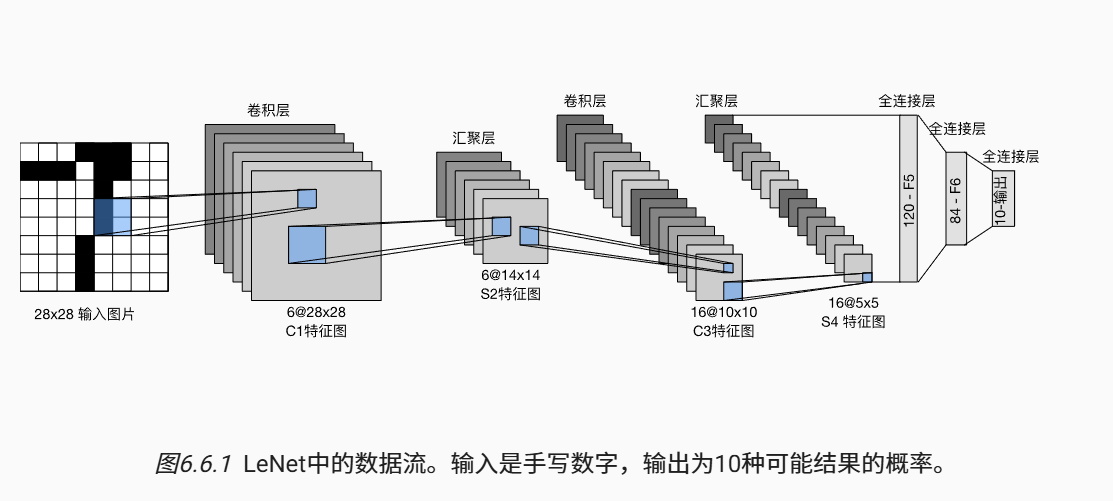

In [1]:
# 每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层
# 虽然ReLU和maxpooling更有效，但是那个年代还没发现

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 输入通道1，输出通道6
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
# 对原始模型做了点小改动，去掉了最后一层的高斯激活，除此之外，这个网络与最初的LeNet-5一致
# 接下来，我们将一个大小为28*28的单通道图像通过LeNet，通过在每一层打印输出的形状，我们可以检查模型

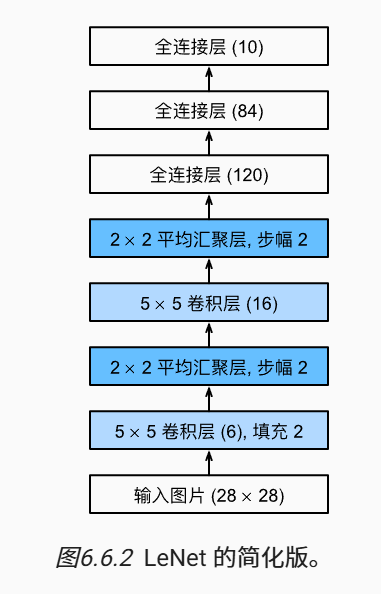

In [12]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [22]:
# 模型训练：Fashion-NMNIST
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [23]:
for X, y in train_iter:
    print(X.shape)
    break

torch.Size([256, 1, 28, 28])


In [15]:
# 虽然卷积神经网络的参数较少，但是与深度的多层感知机相比，它的计算成本仍然很高，因为每个参数都参与更多的乘法
# 通过使用GPU，可以用它加快训练

In [19]:
# 评估。由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [20]:
# 在进行正向和反向传播之前，我们要将每一小批量数据移动到我们指定的设备（例如GPU上）
# 以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化
# 使用Xavier随机初始化模型参数。使用交叉熵函数和小批量随机梯度下降
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()  # 默认返回平均损失值
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):  # X.shape:[256, 1, 28, 28]，X是一个batch的样本
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:  # 每训练1/5的数据，或者到最后一个batch时
                animator.add(epoch + (i + 1) / num_batches,  # 当前训练进度，一个epoch当中求5次
                                (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)  # test acc每个epoch求一次
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
            f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
            f'on {str(device)}')  # 在该设备上每秒处理多少样本数
                    

loss 0.482, train acc 0.819, test acc 0.817
67303.7 examples/sec on cuda:0


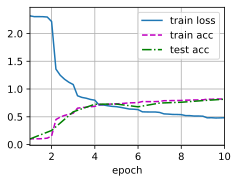

In [25]:
# 评估和训练
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [14]:
torch.cuda.is_available()

True

In [15]:
!nvidia-smi

Tue Dec 24 13:12:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   33C    P8              17W / 170W |   4613MiB / 12288MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
print(torch.__version__)  # PyTorch 版本
print(torch.version.cuda)  # CUDA 版本


2.5.1
11.8
